# ETL con Spark 
---

## Spark Session

In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType

In [2]:
# Config
spark = (
    SparkSession
    .builder
    .appName("Vlc_social")
    .master("local[*]")
    .config("spark.ui.port", "4040")
    .config("spark.driver.host", "localhost")
    .getOrCreate()
)

spark

## Cleaning datasets

### Dataset "Poblacion_municipal.csv"

In [3]:
df_poblacion = spark.read.csv(
    "./data_vlc/Poblacion_municipal.csv",
    header=True,
    inferSchema=True,
    sep=";",
    encoding="ISO-8859-1"
)
# drop cols n change name
df_poblacion = df_poblacion.drop("Sexo", "Periodo")
df_poblacion = df_poblacion.withColumnRenamed("Total", "Poblacion_total")
# remove dots from "Poblacion_total" col
df_poblacion = df_poblacion.withColumn("Poblacion_total", F.regexp_replace(F.col("Poblacion_total"), "\\.", ""))
# change string to float
df_poblacion = df_poblacion.withColumn(
    "Poblacion_total",
    F.when((F.col("Poblacion_total").isNull()) | (F.col("Poblacion_total") == ""), 0).otherwise(F.col("Poblacion_total").cast(FloatType())))

df_poblacion.show(5)
df_poblacion.printSchema()

+--------------------+---------------+
|          Municipios|Poblacion_total|
+--------------------+---------------+
|        46001 Ademuz|         1015.0|
|          46002 Ador|         1755.0|
|      46004 Agullent|         2438.0|
|46042 Aielo de Ma...|         4624.0|
|46043 Aielo de Rugat|          160.0|
+--------------------+---------------+
only showing top 5 rows

root
 |-- Municipios: string (nullable = true)
 |-- Poblacion_total: double (nullable = true)



### Dataset "Renta_media.csv"

In [4]:
df_renta = spark.read.csv(
    "./data_vlc/Renta_media.csv",
    header=True,
    inferSchema=True,
    sep=";",
    encoding="ISO-8859-1"
)
# drop cols n change name
df_renta = df_renta.withColumnRenamed("Total", "Renta_media")
df_renta = df_renta.drop("Indicadores de renta media y mediana", "Distritos", "Secciones", "Periodo")
# remove dots from "Renta_media" col
df_renta = df_renta.withColumn("Renta_media", F.regexp_replace(F.col("Renta_media"), "\\.", ""))
# change string to float
df_renta = df_renta.withColumn(
    "Renta_media",
    F.when((F.col("Renta_media").isNull()) | (F.col("Renta_media") == ""), 0).otherwise(F.col("Renta_media").cast(FloatType())))

df_renta.show(5)
df_renta.printSchema()

+--------------------+-----------+
|          Municipios|Renta_media|
+--------------------+-----------+
|        46001 Ademuz|    12544.0|
|          46002 Ador|    13447.0|
|46003 Atzeneta d'...|    12812.0|
|      46004 Agullent|    12589.0|
|       46005 Alaquàs|    12930.0|
+--------------------+-----------+
only showing top 5 rows

root
 |-- Municipios: string (nullable = true)
 |-- Renta_media: double (nullable = true)



### Dataset "Paro_por_municipios.csv"

In [5]:
df_paro = spark.read.csv(
    "./data_vlc/Paro_por_municipios.csv",
    header=True,
    inferSchema=True,
    sep=";",
    encoding="ISO-8859-1"
)

# only keep valencia
df_paro = df_paro.filter(df_paro["Comunidad Autónoma"] == "Comunitat Valenciana")
# only from one month
df_paro = df_paro.filter(df_paro["Código mes "] == 202501)
# drop unnecessary info
df_paro = df_paro.drop("Código mes ", "mes", "Código de CA", "Comunidad Autónoma", "Codigo Provincia", "Provincia", " Municipio")
# drop last column with the index (odd name)
df_paro = df_paro.drop(df_paro.columns[-1])

# rename cols to snake case
df_paro = df_paro.withColumnRenamed("Codigo Municipio", "Codigo_municipio") \
    .withColumnRenamed("total Paro Registrado", "Total_paro_registrado") \
    .withColumnRenamed("Paro hombre edad < 25", "Paro_hombre_menor_25") \
    .withColumnRenamed("Paro hombre edad 25 -45 ", "Paro_hombre_25_45") \
    .withColumnRenamed("Paro hombre edad >=45", "Paro_hombre_45+") \
    .withColumnRenamed("Paro mujer edad < 25", "Paro_mujer_menor_25") \
    .withColumnRenamed("Paro mujer edad 25 -45 ", "Paro_mujer_25_45") \
    .withColumnRenamed("Paro mujer edad >=45", "Paro_mujer_45+") \
    .withColumnRenamed("Paro Agricultura", "Paro_agricultura") \
    .withColumnRenamed("Paro Industria", "Paro_industria") \
    .withColumnRenamed("Paro Construcción", "Paro_construccion") \
    .withColumnRenamed("Paro Servicios", "Paro_servicios") 

cols_paro_float = [
    "Total_paro_registrado",
    "Paro_hombre_menor_25",
    "Paro_hombre_25_45",
    "Paro_hombre_45+",
    "Paro_mujer_menor_25",
    "Paro_mujer_25_45",
    "Paro_mujer_45+",
    "Paro_agricultura",
    "Paro_industria",
    "Paro_construccion",
    "Paro_servicios"
]
# changes all the "<5" to 3 and make them all float
df_paro = df_paro.select(
    "Codigo_municipio",
    *[
        F.when(F.trim(F.col(c)) == "<5", 3).otherwise(F.regexp_replace(F.col(c), "[\\.\\s]", "")).cast(FloatType())
         .alias(c)
        for c in cols_paro_float
    ]
)
# leave codigo as an int
df_paro = df_paro.withColumn("Codigo_municipio", F.col("Codigo_municipio").cast("int"))

df_paro.show()
df_paro.printSchema()

+----------------+---------------------+--------------------+-----------------+---------------+-------------------+----------------+--------------+----------------+--------------+-----------------+--------------+
|Codigo_municipio|Total_paro_registrado|Paro_hombre_menor_25|Paro_hombre_25_45|Paro_hombre_45+|Paro_mujer_menor_25|Paro_mujer_25_45|Paro_mujer_45+|Paro_agricultura|Paro_industria|Paro_construccion|Paro_servicios|
+----------------+---------------------+--------------------+-----------------+---------------+-------------------+----------------+--------------+----------------+--------------+-----------------+--------------+
|            3001|                 19.0|                 0.0|              3.0|            5.0|                0.0|             5.0|           5.0|             3.0|           3.0|              3.0|          12.0|
|            3002|                339.0|                11.0|             40.0|           85.0|               10.0|            76.0|         117.0| 

### Dataset "MUNICIPIOS.csv"

In [6]:
df_municipios = spark.read.csv(
    "./data_vlc/MUNICIPIOS.csv",
    header=True,
    inferSchema=True,
    sep=";",
    encoding="ISO-8859-1"
)

df_municipios.show()
df_municipios.printSchema()

+----------+-------+-------+--------+-----------+--------------------+--------------+----------+---------+---------------+--------------------+-----------------+-----------------+---------------+--------------+-------------+-------+-------------+
|   COD_INE| ID_REL|COD_GEO|COD_PROV|  PROVINCIA|       NOMBRE_ACTUAL|POBLACION_MUNI|SUPERFICIE|PERIMETRO|COD_INE_CAPITAL|             CAPITAL|POBLACION_CAPITAL|HOJA_MTN25_ETRS89|LONGITUD_ETRS89|LATITUD_ETRS89|   ORIGENCOOR|ALTITUD|ORIGENALTITUD|
+----------+-------+-------+--------+-----------+--------------------+--------------+----------+---------+---------------+--------------------+-----------------+-----------------+---------------+--------------+-------------+-------+-------------+
|1001000000|1010014|   1010|       1|Araba/Álava|    Alegría-Dulantzi|          2975| 1994,5872|    35069|     1001000101|    Alegría-Dulantzi|             2860|           0113-3|    -2,51243731|   42,83981158|         Mapa|    568|          MDT|
|1002000000|

## Final Dataset

### Putting together the info found online

In [7]:
# joins df_poblacion and df_renta dataframes on "municipio" col 
df_social = df_poblacion.join(df_renta, on=["Municipios"], how="inner")
# separates municipios into "codigo_municipio" and "Municipio"
df_social = df_social.withColumn("Codigo_municipio", F.split(F.col("Municipios"), " ").getItem(0))
df_social = df_social.withColumn("Municipios", F.split(F.col("Municipios"), " ").getItem(1))
# joins df_social with df_paro on "codigo_municipio"
df_social = df_social.join(df_paro, on=["Codigo_municipio"], how="inner")
# codigo municipio to int
df_social = df_social.withColumn("Codigo_municipio", F.col("Codigo_municipio").cast("int"))

df_social.show()
df_social.printSchema()

+----------------+-----------------+---------------+-----------+---------------------+--------------------+-----------------+---------------+-------------------+----------------+--------------+----------------+--------------+-----------------+--------------+
|Codigo_municipio|       Municipios|Poblacion_total|Renta_media|Total_paro_registrado|Paro_hombre_menor_25|Paro_hombre_25_45|Paro_hombre_45+|Paro_mujer_menor_25|Paro_mujer_25_45|Paro_mujer_45+|Paro_agricultura|Paro_industria|Paro_construccion|Paro_servicios|
+----------------+-----------------+---------------+-----------+---------------------+--------------------+-----------------+---------------+-------------------+----------------+--------------+----------------+--------------+-----------------+--------------+
|           46001|           Ademuz|         1015.0|    12544.0|                 71.0|                 6.0|              9.0|           20.0|                3.0|            17.0|          15.0|             3.0|           8.

In [8]:
# save df into a csv
df_social.coalesce(1).write.csv(
    "./data_vlc/df_social_cleaned.csv",  
    header=True,                         
    mode="overwrite",
    sep=";", 
    encoding="ISO-8859-1"
)

### Use the dataset saved before to make more based on that data

In [10]:
import pandas as pd
from datetime import datetime
from meteostat import Point, Daily

# files going in
PATH_TU_TABLA = "./data_vlc/part-00000-74c76527-0545-4ecc-abea-8be1009b86a8-c000.csv"  
PATH_NOMENCLATOR = "./data_vlc/MUNICIPIOS.csv"

# helps avoid UnicodeDecodeError
def read_csv_try(path, **kwargs):
    encodings = ["utf-8", "latin-1", "cp1252"]
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc, **kwargs)
        except UnicodeDecodeError:
            continue
    return pd.read_csv(path, encoding="latin-1", engine="python", **kwargs)

# read data
df = read_csv_try(PATH_TU_TABLA, sep=";")
df["Codigo_municipio"] = df["Codigo_municipio"].astype(str).str.strip().str.zfill(5)

# read nomenclator
mun = read_csv_try(PATH_NOMENCLATOR, sep=";")
# we only keep the info we want
mun_small = mun[["COD_GEO", "NOMBRE_ACTUAL", "LATITUD_ETRS89", "LONGITUD_ETRS89"]].copy()
mun_small = mun_small.rename(columns={
    "COD_GEO": "Codigo_municipio",
    "NOMBRE_ACTUAL": "Municipio_oficial",
    "LATITUD_ETRS89": "lat",
    "LONGITUD_ETRS89": "lon",
})

# change to float
def _to_float_coord(x):
    if pd.isna(x):
        return None
    s = str(x).strip().replace(",", ".")
    try:
        return float(s)
    except Exception:
        return None

mun_small["lat"] = mun_small["lat"].apply(_to_float_coord)
mun_small["lon"] = mun_small["lon"].apply(_to_float_coord)

mun_small.head()


,Codigo_municipio,Municipio_oficial,lat,lon
0,1010,Alegría-Dulantzi,42.839812,-2.512437
1,1020,Amurrio,43.054278,-3.000073
2,1030,Aramaio,43.051197,-2.565400
3,1040,Artziniega,43.120844,-3.127917
4,1060,Armiñón,42.723262,-2.871835


In [11]:
# merge with INE
mun_small["Codigo_municipio"] = mun_small["Codigo_municipio"].astype(str).str.strip().str.zfill(5)
df2 = df.merge(mun_small, on="Codigo_municipio", how="left")
df2.head()

,Codigo_municipio,Municipios,Poblacion_total,Renta_media,Total_paro_registrado,Paro_hombre_menor_25,Paro_hombre_25_45,Paro_hombre_45+,Paro_mujer_menor_25,Paro_mujer_25_45,Paro_mujer_45+,Paro_agricultura,Paro_industria,Paro_construccion,Paro_servicios,Demanda_score,Demanda_comedor,Municipio_oficial,lat,lon
0,46001,Ademuz,1015.0,12544.0,71.0,6.0,9.0,20.0,3.0,17.0,15.0,3.0,8.0,8.0,47.0,0.129582,2,València,39.475344,-0.375657
1,46002,Ador,1755.0,13447.0,80.0,3.0,10.0,21.0,3.0,16.0,31.0,3.0,11.0,8.0,59.0,0.117586,2,NaN,NaN,NaN
2,46003,Atzeneta,1193.0,12812.0,70.0,3.0,6.0,17.0,3.0,10.0,32.0,0.0,25.0,3.0,40.0,0.125976,2,Ademuz,40.060770,-1.286141
3,46004,Agullent,2438.0,12589.0,134.0,3.0,13.0,30.0,0.0,17.0,72.0,3.0,45.0,3.0,81.0,0.130010,2,NaN,NaN,NaN
4,46005,Alaquàs,30166.0,12930.0,2247.0,102.0,285.0,432.0,77.0,457.0,894.0,23.0,316.0,139.0,1553.0,0.153160,2,NaN,NaN,NaN


In [12]:
# winter tempt data
start = datetime(2015, 1, 1)
end = datetime(2024, 12, 31)

def winter_metrics(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return pd.Series({"Temp_min_invierno": 0.8, "Prec_max_invierno": 76.6})

    # will get it in degrees
    p = Point(float(lat), float(lon))

    data = Daily(p, start, end).fetch()
    if data.empty:
        return pd.Series({"Temp_min_invierno": 0.8, "Prec_max_invierno": 76.6})

    data = data.reset_index()
    data["month"] = data["time"].dt.month

    # winter:dec- jan- feb
    w = data[data["month"].isin([12, 1, 2])]

    tmin_w = w["tmin"].min() if "tmin" in w.columns else None
    prcp_w = w["prcp"].max() if "prcp" in w.columns else None

    return pd.Series({
        "Temp_min_invierno": tmin_w,
        "Prec_max_invierno": prcp_w
    })

df2[["Temp_min_invierno", "Prec_max_invierno"]] = df2.apply(
    lambda r: winter_metrics(r["lat"], r["lon"]),
    axis=1
)

# Export it into a csv
# Use the actual column name from the merged nomenclator
out = df2[["Codigo_municipio", "Municipios", "Temp_min_invierno", "Prec_max_invierno"]].copy()
out.to_csv("municipios_con_invierno.csv", sep=";", index=False, encoding="utf-8")

In [13]:
from sklearn.preprocessing import MinMaxScaler

cols = [
    "Renta_media",
    "Demanda_score"
]

df_qol = df2.copy()

# variables we derived
df_qol["paro_pct"] = df_qol["Total_paro_registrado"] / df_qol["Poblacion_total"]
df_qol["paro_servicios_pct"] = df_qol["Paro_servicios"] / df_qol["Total_paro_registrado"]

# normalize 0–1
scaler = MinMaxScaler()
df_qol[["Renta_norm", "Demanda_norm", "Paro_norm", "Servicios_norm"]] = scaler.fit_transform(
    df_qol[[
        "Renta_media",
        "Demanda_score",
        "paro_pct",
        "paro_servicios_pct"
    ]]
)

# index for calidad_vida
df_qol["Calidad_vida_media"] = (
    0.35 * df_qol["Renta_norm"] +
    0.30 * (1 - df_qol["Paro_norm"]) +
    0.20 * df_qol["Servicios_norm"] +
    0.15 * (1 - df_qol["Demanda_norm"])
)

# final result
df_final = df_qol[[
    "Codigo_municipio",
    "Municipios",
    "Calidad_vida_media"
]]

df_final.head()
df_final.to_csv("municipios_calidad_vida.csv", sep=";", index=False, encoding="utf-8")


### Dataset "municipios_calidad_vida.csv"

In [15]:
df_calidad = spark.read.csv(
    "./data_vlc/municipios_calidad_vida.csv",
    header=True,
    inferSchema=True,
    sep=";",
    encoding="ISO-8859-1"
)

#drop municipios
df_calidad = df_calidad.drop("Municipios")
df_calidad.show()
df_calidad.printSchema()

+----------------+------------------+
|Codigo_municipio|Calidad_vida_media|
+----------------+------------------+
|           46001|0.5758872242744002|
|           46002|0.6742105994867315|
|           46003|0.5784616364033883|
|           46004|0.5934530842870244|
|           46005|0.5761145715360012|
|           46006|0.5811069393062017|
|           46007|0.6032876892577375|
|           46008|0.6157908466157145|
|           46009|0.7246953749787703|
|           46010|0.7148880335835571|
|           46011|0.5951471595793038|
|           46012|0.6994398720623912|
|           46013|0.7558503937723401|
|           46014|0.6867364060171356|
|           46015|0.6480194485463662|
|           46016|0.6562489194883243|
|           46017|0.6090547149584833|
|           46018|0.6913766151763372|
|           46019|0.6518209088307981|
|           46020|0.5950310491101053|
+----------------+------------------+
only showing top 20 rows

root
 |-- Codigo_municipio: integer (nullable = true)
 |-- Cal

### Dataset "municipios_con_invierno.csv"

In [16]:
df_invierno = spark.read.csv(
    "./data_vlc/municipios_con_invierno.csv",
    header=True,
    inferSchema=True,
    sep=";",
    encoding="ISO-8859-1"
)

# drop municipios
df_invierno = df_invierno.drop("Municipios")
df_invierno.show()
df_invierno.printSchema()

+----------------+-----------------+-----------------+
|Codigo_municipio|Temp_min_invierno|Prec_max_invierno|
+----------------+-----------------+-----------------+
|           46001|              0.8|             76.6|
|           46002|              0.8|             76.6|
|           46003|              0.8|             76.6|
|           46004|              0.8|             76.6|
|           46005|              0.8|             76.6|
|           46006|              0.8|             76.6|
|           46007|              0.8|             76.6|
|           46008|              0.8|             76.6|
|           46009|              0.8|             76.6|
|           46010|              0.8|             76.6|
|           46011|              0.8|             76.6|
|           46012|              0.8|             76.6|
|           46013|              0.8|             76.6|
|           46014|              0.8|             76.6|
|           46015|             -2.0|             76.6|
|         

### Putting together ALL of the data collected and made

In [17]:
# join the social df with "municipios_con_invierno.csv"
df_social = df_invierno.join(df_social, on=["Codigo_municipio"], how="inner")
df_social.show()
df_social.printSchema()

+----------------+-----------------+-----------------+-----------------+---------------+-----------+---------------------+--------------------+-----------------+---------------+-------------------+----------------+--------------+----------------+--------------+-----------------+--------------+
|Codigo_municipio|Temp_min_invierno|Prec_max_invierno|       Municipios|Poblacion_total|Renta_media|Total_paro_registrado|Paro_hombre_menor_25|Paro_hombre_25_45|Paro_hombre_45+|Paro_mujer_menor_25|Paro_mujer_25_45|Paro_mujer_45+|Paro_agricultura|Paro_industria|Paro_construccion|Paro_servicios|
+----------------+-----------------+-----------------+-----------------+---------------+-----------+---------------------+--------------------+-----------------+---------------+-------------------+----------------+--------------+----------------+--------------+-----------------+--------------+
|           46001|              0.8|             76.6|           Ademuz|         1015.0|    12544.0|               

In [18]:
# join the social df with "municipios_calidad_vida.csv"
df_social = df_calidad.join(df_social, on=["Codigo_municipio"], how="inner")
df_social.show()
df_social.printSchema()

+----------------+------------------+-----------------+-----------------+-----------------+---------------+-----------+---------------------+--------------------+-----------------+---------------+-------------------+----------------+--------------+----------------+--------------+-----------------+--------------+
|Codigo_municipio|Calidad_vida_media|Temp_min_invierno|Prec_max_invierno|       Municipios|Poblacion_total|Renta_media|Total_paro_registrado|Paro_hombre_menor_25|Paro_hombre_25_45|Paro_hombre_45+|Paro_mujer_menor_25|Paro_mujer_25_45|Paro_mujer_45+|Paro_agricultura|Paro_industria|Paro_construccion|Paro_servicios|
+----------------+------------------+-----------------+-----------------+-----------------+---------------+-----------+---------------------+--------------------+-----------------+---------------+-------------------+----------------+--------------+----------------+--------------+-----------------+--------------+
|           46001|0.5758872242744002|              0.8|   

In [19]:
# reorder so it looks organized
df_social = df_social.select(
    "Codigo_municipio",
    "Municipios",
    "Temp_min_invierno",
    "Prec_max_invierno",
    "Calidad_vida_media",
    "Poblacion_total",
    "Renta_media",
    "Total_paro_registrado",
    "Paro_hombre_menor_25",
    "Paro_hombre_25_45",
    "Paro_hombre_45+",
    "Paro_mujer_menor_25",
    "Paro_mujer_25_45",
    "Paro_mujer_45+",
    "Paro_agricultura",
    "Paro_industria",
    "Paro_construccion",
    "Paro_servicios"
).orderBy("Codigo_municipio")

df_social.show()
df_social.printSchema()

+----------------+-----------------+-----------------+-----------------+------------------+---------------+-----------+---------------------+--------------------+-----------------+---------------+-------------------+----------------+--------------+----------------+--------------+-----------------+--------------+
|Codigo_municipio|       Municipios|Temp_min_invierno|Prec_max_invierno|Calidad_vida_media|Poblacion_total|Renta_media|Total_paro_registrado|Paro_hombre_menor_25|Paro_hombre_25_45|Paro_hombre_45+|Paro_mujer_menor_25|Paro_mujer_25_45|Paro_mujer_45+|Paro_agricultura|Paro_industria|Paro_construccion|Paro_servicios|
+----------------+-----------------+-----------------+-----------------+------------------+---------------+-----------+---------------------+--------------------+-----------------+---------------+-------------------+----------------+--------------+----------------+--------------+-----------------+--------------+
|           46001|           Ademuz|              0.8|    

### Add a column that measures the demand for the dinner

In [23]:
df_social = df_social.drop("demanda_score", "Demanda")
df_social.show()

+----------------+-----------------+-----------------+-----------------+------------------+---------------+-----------+---------------------+--------------------+-----------------+---------------+-------------------+----------------+--------------+----------------+--------------+-----------------+--------------+
|Codigo_municipio|       Municipios|Temp_min_invierno|Prec_max_invierno|Calidad_vida_media|Poblacion_total|Renta_media|Total_paro_registrado|Paro_hombre_menor_25|Paro_hombre_25_45|Paro_hombre_45+|Paro_mujer_menor_25|Paro_mujer_25_45|Paro_mujer_45+|Paro_agricultura|Paro_industria|Paro_construccion|Paro_servicios|
+----------------+-----------------+-----------------+-----------------+------------------+---------------+-----------+---------------------+--------------------+-----------------+---------------+-------------------+----------------+--------------+----------------+--------------+-----------------+--------------+
|           46001|           Ademuz|              0.8|    

In [ ]:
df_social = df_social.withColumn(
    "demanda_raw",

    0.4 * F.try_divide(F.col("Total_paro_registrado"), F.col("Poblacion_total"))
    +
    0.2 * F.when(F.col("Renta_media") > 0, 10000 / F.col("Renta_media")).otherwise(0)
    +
    0.2 * (F.abs(F.col("Temp_min_invierno") - 22.0) / 20.0)
    +
    0.2 * (F.log10(F.when(F.col("Poblacion_total") > 0, F.col("Poblacion_total")).otherwise(1)) / 5)
)

df_social = df_social.withColumn(
    "Demanda",
    F.when(F.col("demanda_score") < 0.2, 1)
     .when(F.col("demanda_score") < 0.4, 2)
     .when(F.col("demanda_score") < 0.6, 3)
     .when(F.col("demanda_score") < 0.8, 4)
     .otherwise(5)
)

df_social.groupBy("Demanda").count().orderBy("Demanda").show()
df_social.show()
df_social.printSchema()

+-------+-----+
|Demanda|count|
+-------+-----+
|      1|    3|
|      2|    1|
|      3|   59|
|      4|  167|
|      5|   36|
+-------+-----+

+----------------+-----------------+-----------------+-----------------+------------------+---------------+-----------+---------------------+--------------------+-----------------+---------------+-------------------+----------------+--------------+----------------+--------------+-----------------+--------------+-------------------+------------------+-------+
|Codigo_municipio|       Municipios|Temp_min_invierno|Prec_max_invierno|Calidad_vida_media|Poblacion_total|Renta_media|Total_paro_registrado|Paro_hombre_menor_25|Paro_hombre_25_45|Paro_hombre_45+|Paro_mujer_menor_25|Paro_mujer_25_45|Paro_mujer_45+|Paro_agricultura|Paro_industria|Paro_construccion|Paro_servicios|        demanda_raw|     demanda_score|Demanda|
+----------------+-----------------+-----------------+-----------------+------------------+---------------+-----------+--------------


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



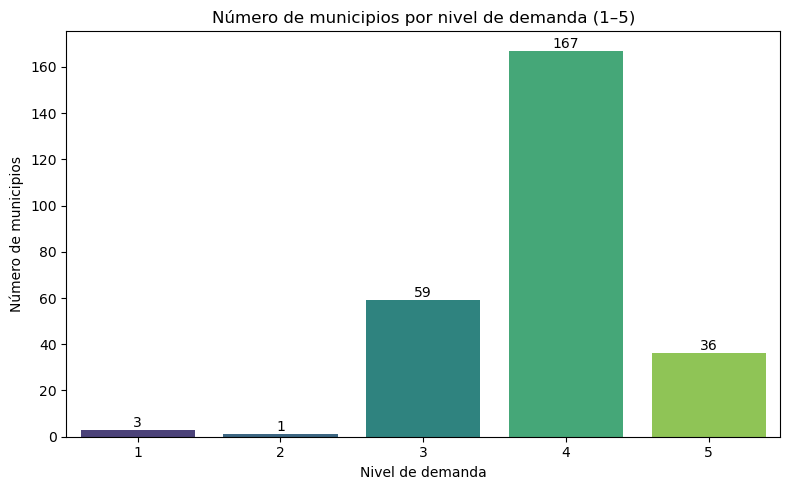

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# count municipios per demand level
df_counts = (df_social.groupBy("demanda").count().orderBy("demanda"))
pdf_counts = df_counts.toPandas()

# plot the graph
plt.figure(figsize=(8, 5))
sns.barplot(
    data=pdf_counts,
    x="demanda",
    y="count",
    palette="viridis"
)

# labels
for index, row in pdf_counts.iterrows():
    plt.text(
        x=index,
        y=row["count"],
        s=row["count"],
        ha="center",
        va="bottom"
    )

plt.title("Número de municipios por nivel de demanda (1-5)")
plt.xlabel("Nivel de demanda")
plt.ylabel("Número de municipios")
plt.xticks([0,1,2,3,4], [1,2,3,4,5])
plt.tight_layout()
plt.show()


In [32]:
# export final csv
df_social.coalesce(1).write.csv(
    "./data_vlc/final_df.csv",  
    header=True,                         
    mode="overwrite",
    sep=";", 
    encoding="ISO-8859-1"
)